In [75]:
import numpy as np
import matplotlib.pyplot as plt
from torch import  optim
import torch.nn as nn
import torch
import copy
import torch.nn.functional as F
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [76]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32, output_size)
    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        
        return x

In [77]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

def get_dataset(dataset_name):
    dataset = MNIST(root='./data', train=True, download=True, transform=transform)

    return dataset

def get_dataloader(dataset_name, batch_size=64, shuffle=True):
    dataset = get_dataset(dataset_name)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

batch_size = 128

train_loader_mnist = get_dataloader('mnist', batch_size=128, shuffle=True)
test_loader_mnist = get_dataloader('mnist', batch_size=128, shuffle=False)

trainset = MNIST('./data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = MNIST('./data', train = True, download = True, transform = transform)
test_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
num_trains = 8


def train(model, train_loader, device, lr=0.001, epochs=100, criterion = nn.CrossEntropyLoss()):
    # criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    epoch_weights = []
    grad_per_iter = [] 
    loss_per_iter = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            # 假设我们需要将输入展平（对于图像数据）
            inputs = inputs.view(inputs.size(0), -1)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loss_per_iter.append(loss.item())
            
            
            grad_all_itr = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    grad_all_itr += (p.grad.cpu().data.numpy() ** 2).sum()
            grad_norm = grad_all_itr ** 0.5
            grad_per_iter.append(grad_norm)
            
        
        
        if epoch % 3 == 0:
            epoch_weights.append(copy.deepcopy(model.state_dict()))

        epoch_loss = running_loss / len(train_loader)


        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

    print('Finished Training')
    
    return epoch_weights, grad_per_iter, loss_per_iter
    


In [78]:
weights = {}
for i in range(num_trains):
    model = Model(28*28, 10).to(device)
    epoch_weights,_,_ = train(model, train_loader, device = device, lr=0.001, epochs=num_epochs, criterion=nn.CrossEntropyLoss())   
    weights[i] = epoch_weights

Epoch [1/50], Loss: 0.5491
Epoch [2/50], Loss: 0.2504
Epoch [3/50], Loss: 0.1837
Epoch [4/50], Loss: 0.1460
Epoch [5/50], Loss: 0.1254
Epoch [6/50], Loss: 0.1068
Epoch [7/50], Loss: 0.0950
Epoch [8/50], Loss: 0.0843
Epoch [9/50], Loss: 0.0750
Epoch [10/50], Loss: 0.0701
Epoch [11/50], Loss: 0.0624
Epoch [12/50], Loss: 0.0595
Epoch [13/50], Loss: 0.0522
Epoch [14/50], Loss: 0.0526
Epoch [15/50], Loss: 0.0458
Epoch [16/50], Loss: 0.0460
Epoch [17/50], Loss: 0.0393
Epoch [18/50], Loss: 0.0381
Epoch [19/50], Loss: 0.0367
Epoch [20/50], Loss: 0.0338
Epoch [21/50], Loss: 0.0309
Epoch [22/50], Loss: 0.0318
Epoch [23/50], Loss: 0.0290
Epoch [24/50], Loss: 0.0263
Epoch [25/50], Loss: 0.0261
Epoch [26/50], Loss: 0.0244
Epoch [27/50], Loss: 0.0260
Epoch [28/50], Loss: 0.0226
Epoch [29/50], Loss: 0.0236
Epoch [30/50], Loss: 0.0204
Epoch [31/50], Loss: 0.0167
Epoch [32/50], Loss: 0.0202
Epoch [33/50], Loss: 0.0235
Epoch [34/50], Loss: 0.0181
Epoch [35/50], Loss: 0.0174
Epoch [36/50], Loss: 0.0140
E

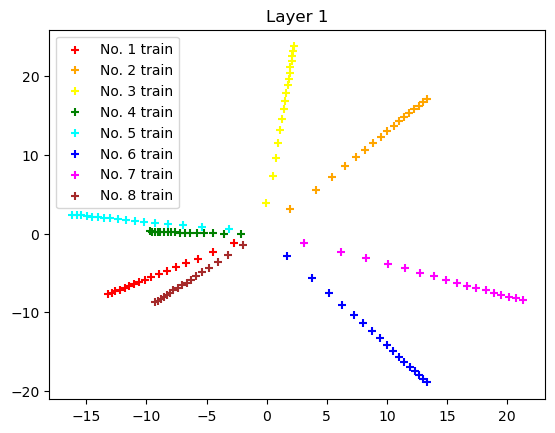

In [79]:

from sklearn.decomposition import PCA 
n_samples_per_session = len(weights[0])
n_samples = num_trains * n_samples_per_session 
n_features = weights[0][0]['fc1.weight'].cpu().numpy().flatten().shape[0] 

PCA_input_data = np.zeros((n_samples, n_features))



for t in range(num_trains):
    for i in range(n_samples_per_session): 
        PCA_input_data[t * n_samples_per_session + i, :] = weights[t][i]['fc1.weight'].flatten().cpu().numpy()


reduced_data = PCA(n_components = 2).fit_transform(PCA_input_data)


colors = ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "brown"]
for t in range(num_trains):
    plt.scatter(reduced_data.T[0][t*n_samples_per_session:(t+1)*n_samples_per_session], reduced_data.T[1][t*n_samples_per_session:(t+1)*n_samples_per_session], color=colors[t], marker='+', label=f"No. {t+1} train")
plt.legend()
plt.title("Layer 1")
plt.show()

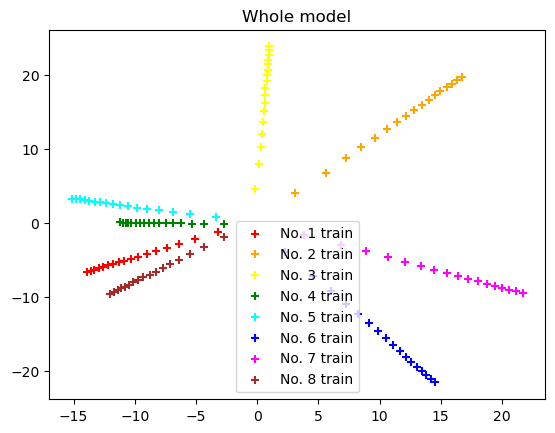

In [80]:

n_samples_per_session = len(weights[0])
n_samples = num_trains * n_samples_per_session 
n_features = weights[0][0]['fc1.weight'].cpu().numpy().flatten().shape[0] + weights[0][0]['fc2.weight'].cpu().numpy().flatten().shape[0] + weights[0][0]['fc3.weight'].cpu().numpy().flatten().shape[0]+ weights[0][0]['fc4.weight'].cpu().numpy().flatten().shape[0]


PCA_input_data = np.zeros((n_samples, n_features))



# populate high-dim input tensor 
for t in range(num_trains):
    for i in range(n_samples_per_session):
        layer_weights = [weights[t][i][f'{layer}.weight'].flatten().cpu().numpy() for layer in ['fc1', 'fc2', 'fc3', 'fc4']]
        PCA_input_data[t * n_samples_per_session + i, :] = np.concatenate(layer_weights)



reduced_data = PCA(n_components = 2).fit_transform(PCA_input_data)


colors = ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "brown"]
for t in range(num_trains):
    plt.scatter(reduced_data.T[0][t*n_samples_per_session:(t+1)*n_samples_per_session], reduced_data.T[1][t*n_samples_per_session:(t+1)*n_samples_per_session], color=colors[t], marker='+', label=f"No. {t+1} train")
plt.legend()
plt.title("Whole model")
plt.show()

In [81]:
model = Model(28*28, 10).to(device)
_,grad_per_iter,loss_per_iter = train(model, train_loader, device = device, lr=0.001, epochs=50)   

Epoch [1/50], Loss: 0.5102
Epoch [2/50], Loss: 0.2343
Epoch [3/50], Loss: 0.1723
Epoch [4/50], Loss: 0.1356
Epoch [5/50], Loss: 0.1121
Epoch [6/50], Loss: 0.0979
Epoch [7/50], Loss: 0.0860
Epoch [8/50], Loss: 0.0771
Epoch [9/50], Loss: 0.0671
Epoch [10/50], Loss: 0.0646
Epoch [11/50], Loss: 0.0553
Epoch [12/50], Loss: 0.0527
Epoch [13/50], Loss: 0.0477
Epoch [14/50], Loss: 0.0427
Epoch [15/50], Loss: 0.0442
Epoch [16/50], Loss: 0.0376
Epoch [17/50], Loss: 0.0354
Epoch [18/50], Loss: 0.0334
Epoch [19/50], Loss: 0.0318
Epoch [20/50], Loss: 0.0281
Epoch [21/50], Loss: 0.0293
Epoch [22/50], Loss: 0.0283
Epoch [23/50], Loss: 0.0266
Epoch [24/50], Loss: 0.0273
Epoch [25/50], Loss: 0.0222
Epoch [26/50], Loss: 0.0212
Epoch [27/50], Loss: 0.0216
Epoch [28/50], Loss: 0.0213
Epoch [29/50], Loss: 0.0223
Epoch [30/50], Loss: 0.0201
Epoch [31/50], Loss: 0.0185
Epoch [32/50], Loss: 0.0198
Epoch [33/50], Loss: 0.0160
Epoch [34/50], Loss: 0.0204
Epoch [35/50], Loss: 0.0161
Epoch [36/50], Loss: 0.0160
E

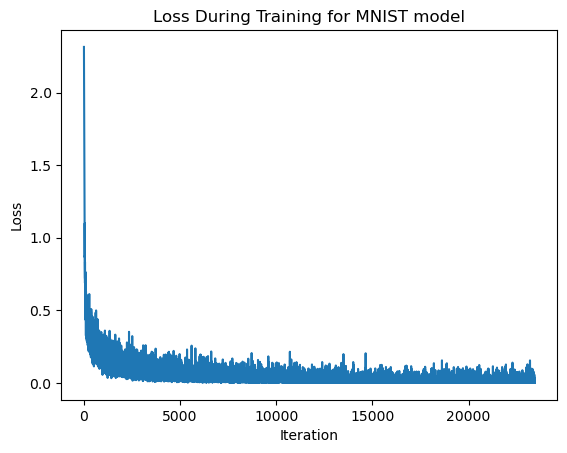

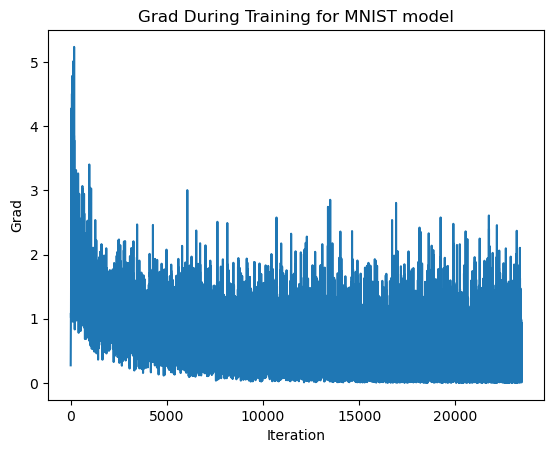

In [82]:
plt.figure()
plt.plot(loss_per_iter)
plt.title('Loss During Training for MNIST model')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


plt.figure()
plt.plot(grad_per_iter)
plt.title('Grad During Training for MNIST model')
plt.xlabel("Iteration")
plt.ylabel("Grad")
plt.show()

In [83]:
def func1(x):
    return np.sin(5 * np.pi * x) / (5 * np.pi * x)
x = np.linspace(2e-6, 2.0, 1000)
y1 = func1(x)
from torch.utils.data import TensorDataset, DataLoader


x_train_tensor = torch.tensor(x, dtype=torch.float32, device=device).view(-1, 1) 
y_train_tensor = torch.tensor(y1, dtype=torch.float32, device=device).view(-1, 1)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
model = Model(1, 1).to(device)

_,grad_per_iter,loss_per_iter = train(model, train_loader, device = device, lr=0.001, epochs=700, criterion=torch.nn.MSELoss())   

Epoch [1/700], Loss: 0.0579
Epoch [2/700], Loss: 0.0517
Epoch [3/700], Loss: 0.0495
Epoch [4/700], Loss: 0.0482
Epoch [5/700], Loss: 0.0464
Epoch [6/700], Loss: 0.0445
Epoch [7/700], Loss: 0.0429
Epoch [8/700], Loss: 0.0416
Epoch [9/700], Loss: 0.0407
Epoch [10/700], Loss: 0.0398
Epoch [11/700], Loss: 0.0391
Epoch [12/700], Loss: 0.0383
Epoch [13/700], Loss: 0.0376
Epoch [14/700], Loss: 0.0370
Epoch [15/700], Loss: 0.0364
Epoch [16/700], Loss: 0.0359
Epoch [17/700], Loss: 0.0355
Epoch [18/700], Loss: 0.0350
Epoch [19/700], Loss: 0.0344
Epoch [20/700], Loss: 0.0338
Epoch [21/700], Loss: 0.0332
Epoch [22/700], Loss: 0.0326
Epoch [23/700], Loss: 0.0320
Epoch [24/700], Loss: 0.0314
Epoch [25/700], Loss: 0.0308
Epoch [26/700], Loss: 0.0301
Epoch [27/700], Loss: 0.0296
Epoch [28/700], Loss: 0.0290
Epoch [29/700], Loss: 0.0285
Epoch [30/700], Loss: 0.0278
Epoch [31/700], Loss: 0.0271
Epoch [32/700], Loss: 0.0265
Epoch [33/700], Loss: 0.0260
Epoch [34/700], Loss: 0.0254
Epoch [35/700], Loss: 0

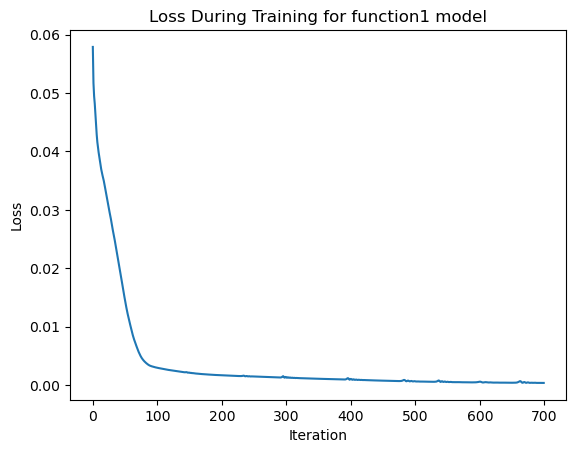

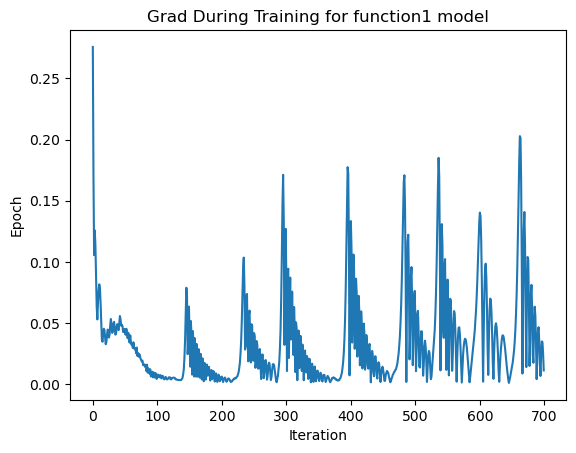

In [84]:
plt.figure()
plt.plot(loss_per_iter)
plt.title('Loss During Training for function1 model')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


plt.figure()
plt.plot(grad_per_iter)
plt.title('Grad During Training for function1 model')
plt.xlabel("Iteration")
plt.ylabel("Epoch")
plt.show()